In [ ]:
!pip install facenet-pytorch

In [2]:
import kagglehub

path = kagglehub.dataset_download("alfredhhw/adiencegender")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/adiencegender


In [3]:
IMAGE_DIR = path + "/AdienceGender/aligned/"

In [4]:
import os
import re
import numpy as np
import pandas as pd
import torch
from PIL import Image
import cv2
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.manifold import TSNE

In [5]:
adience_df = pd.read_csv("https://drive.google.com/uc?id=11a8GW8PXR5jYWQCb73-7IzOTYUR6abQc&export=download")

In [6]:
adience_df

,image_path,age
0,30601258@N03/landmark_aligned_face.1.103996468...,"(25, 32)"
1,30601258@N03/landmark_aligned_face.2.104248158...,"(25, 32)"
2,30601258@N03/landmark_aligned_face.1.104379798...,"(25, 32)"
3,30601258@N03/landmark_aligned_face.3.104379798...,"(25, 32)"
4,30601258@N03/landmark_aligned_face.2.118166449...,"(25, 32)"
...,...,...
13963,101515718@N03/landmark_aligned_face.2280.10587...,"(25, 32)"
13964,101515718@N03/landmark_aligned_face.2278.10587...,"(25, 32)"
13965,101515718@N03/landmark_aligned_face.2279.10587...,"(25, 32)"
13966,50458575@N08/landmark_aligned_face.2281.942669...,"(25, 32)"


In [7]:
adience_df['image_path'] = adience_df['image_path'].astype(str)
adience_df['age'] = adience_df['age'].apply(eval)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
mtcnn = MTCNN(image_size=224, select_largest=True, keep_all=True, device=device)

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3, fill=0),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [12]:
adience_df = adience_df[adience_df['age'] != (8, 23)]

In [13]:
sorted(adience_df["age"].unique())

[(0, 2), (4, 6), (8, 12), (15, 20), (25, 32), (38, 48), (48, 53), (60, 100)]

In [14]:
class AdienceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.age_range_to_index = {
            age_range : idx
            for idx, age_range in enumerate(sorted(self.dataframe["age"].unique()))
        }
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row["image_path"]
        label = self.age_range_to_index[row["age"]]
        label = torch.tensor(label, dtype=torch.long)

        image = Image.open(IMAGE_DIR + image_path)
        image = image.resize((224, 224))

        faces, _ = mtcnn.detect(image)

        if faces is None:
            image = Image.open(IMAGE_DIR + image_path)
            image = image.resize((224, 224))
        else:
            largest_face_box = faces[0]
            image = image.crop((largest_face_box[0], largest_face_box[1], largest_face_box[2], largest_face_box[3]))

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
dataset = AdienceDataset(adience_df, transform=transform)



train_size = int(0.7 * len(dataset))

test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
num_classes = 8

In [18]:
model = models.densenet121(pretrained=True)

model.classifier = nn.Linear(model.classifier.in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 145MB/s] 


In [19]:
model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  # Total loss across all samples
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)  # Average loss per sample
    train_accuracy = 100 * correct_train / total_train
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

print("Training complete.")

Epoch [1/5], Training Loss: 0.9757, Training Accuracy: 61.63%
Epoch [2/5], Training Loss: 0.8678, Training Accuracy: 66.21%
Epoch [3/5], Training Loss: 0.8085, Training Accuracy: 68.32%
Epoch [4/5], Training Loss: 0.7416, Training Accuracy: 70.81%
Epoch [5/5], Training Loss: 0.7035, Training Accuracy: 72.83%
Training complete.


In [32]:
torch.save(model.state_dict(), 'densenet121_weights.pth')

In [25]:
model.eval()
correct_test = 0
total_test = 0

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

conf_matrix = confusion_matrix(all_labels, all_predictions)
precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_predictions)

print("Confusion Matrix:\n", conf_matrix)
print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1_score)
print("Samples per class:", support)

Test Accuracy: 70.18%
Confusion Matrix:
 [[ 638   38    4    3    2    0    0    0]
 [  57  272   80   10   11    1    2    1]
 [   8   16  290   68   56    2    3    1]
 [   3    0   14  209   88    8   11    2]
 [   4    6   19  133 1008  110   40    2]
 [   4    2    6   32  142  248   62   20]
 [   1    0    2    0   17   28  130   28]
 [   0    0    2    2    7   12   61  102]]

Precision per class: [0.89230769 0.81437126 0.69544365 0.45733042 0.75732532 0.60635697
 0.42071197 0.65384615]
Recall per class: [0.93138686 0.62672811 0.65315315 0.6238806  0.76248109 0.48062016
 0.63106796 0.5483871 ]
F1-score per class: [0.91142857 0.70833333 0.67363531 0.52777778 0.75989446 0.53621622
 0.50485437 0.59649123]
Samples per class: [ 685  434  444  335 1322  516  206  186]


In [ ]:
feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))
features = []
labels = []

with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        outputs = feature_extractor(images)
        features.append(outputs.view(outputs.size(0), -1).cpu())
        labels.append(label.cpu())

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

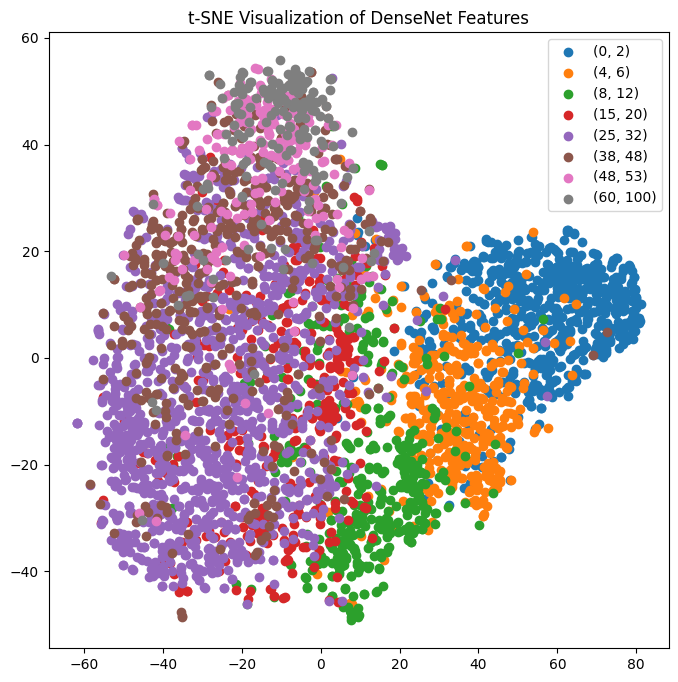

In [29]:
reverse_mapping = {v: k for k, v in dataset.age_range_to_index.items()}
plt.figure(figsize=(8, 8))
for label in set(labels):
    plt.scatter(
        reduced_features[labels == label, 0],
        reduced_features[labels == label, 1],
        label=str(reverse_mapping.get(label, "Unknown"))
    )
plt.legend()
plt.title("t-SNE Visualization of DenseNet Features")
plt.show()